In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['axes.grid'] = True

In [4]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))
num_temps = 100

In [5]:
def errs(errs):
    return np.array([sum(errs[i*512:(i+1)*512])/512 for i in range(num_temps)])

def stds_err(errs):
    return np.array([np.std(errs[i*512:(i+1)*512]) for i in range(num_temps)])

In [6]:
Jd = -0.3
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

opt_epochs = np.load('opt_epochs.npy', allow_pickle='TRUE').item()
epochs = opt_epochs[Jd]
    
errs_ = []
outs_ = []
Ls = [20, 30, 60, 80, 120]
for i, L in enumerate(Ls):
    num_epochs = epochs[i]
    #with open(f'data_errors/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
    with open(f'data_errors/{Jd}_{L}_{num_temps}_{num_epochs}_epochs_modified_tc.npy', 'rb') as f:
        errs_.append(np.load(f)) 
    #with open(f'data_outputs/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
    with open(f'data_outputs/{Jd}_{L}_{num_temps}_{num_epochs}_epochs_modified_tc.npy', 'rb') as f:
        outs_.append(np.load(f))

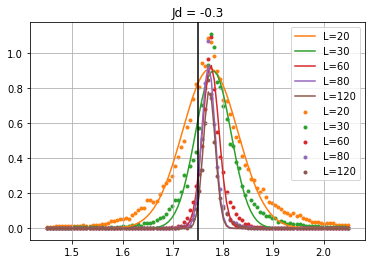

In [12]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))


def gaussian_fit(x, y, p):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, p0=p)
    return popt, pcov

p_ = [[np.max(stds_err(outs_[j])), T[np.argmax(stds_err(outs_[j]))], np.std(stds_err(outs_[j])) / 2] for j in range(len(Ls))]
#p_ = [[np.max(errs(errs_[j])), T[np.argmax(errs(errs_[j]))], np.std(errs(errs_[j])) / 2] for j in range(len(Ls))]

tmp = [gaussian_fit(y=errs(errs_[j]), x=T, p=p_[j]) for j in range(len(Ls))]

popt_ = [tmp[j][0] for j in range(len(Ls))] 
pcov_ = [tmp[j][1] for j in range(len(Ls))]

plt.figure()

for j in range(len(Ls)):
    plt.plot(T, gaussian(T, popt_[j][0], popt_[j][1], popt_[j][2]), label=f'L={Ls[j]}', c=f'C{j+1}')
    #plt.scatter(T, stds_err(outs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

plt.axvline(x=T_c, color='black')
plt.title(f'Jd = {Jd}')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [13]:
perr_ = np.array([np.sqrt(np.diag(pcov_[j])) for j in range(len(Ls))])
perr_

array([[0.00224354, 0.00113625, 0.00113625],
       [0.00162304, 0.000834  , 0.000834  ],
       [0.00077865, 0.00038549, 0.00038549],
       [0.00048973, 0.00024232, 0.00024232],
       [0.00035582, 0.00020786, 0.00020786]])

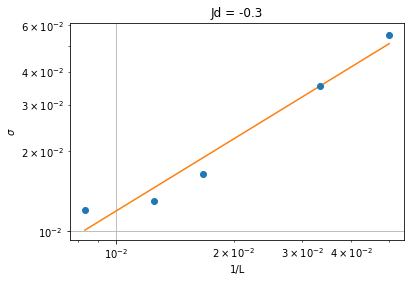

In [14]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80, 120]])
cs = np.abs(np.array(popt_)[:, 2]) # sigma 

pl_00, pcov_00 = line_fit(y=np.log(np.abs(cs)), x=np.log(ls))
#pl_00 = np.polyfit(np.log(ls), np.log(cs), 1)

#plt.scatter(ls, cs, color='red')
plt.errorbar(ls, cs, yerr=perr_[:, 2], fmt="o")
#plt.plot(ls, np.exp(np.poly1d(pl_00)(np.log(ls))))
plt.plot(ls, np.exp(line(np.log(ls), pl_00[0], pl_00[1])))

plt.title(f'Jd = {Jd}')
plt.xlabel('1/L')
plt.ylabel('$\sigma$')
plt.xscale('log')
plt.yscale('log')
plt.savefig(f'images/{Jd}-sigma-bce.png')

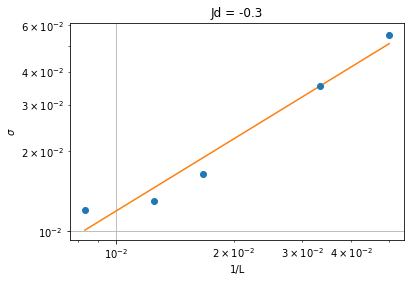

In [10]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80, 120]])
cs = np.abs(np.array(popt_)[:, 2]) # sigma 

pl_00, pcov_00 = line_fit(y=np.log(np.abs(cs)), x=np.log(ls))
#pl_00 = np.polyfit(np.log(ls), np.log(cs), 1)

#plt.scatter(ls, cs, color='red')
plt.errorbar(ls, cs, yerr=perr_[:, 2], fmt="o")
#plt.plot(ls, np.exp(np.poly1d(pl_00)(np.log(ls))))
plt.plot(ls, np.exp(line(np.log(ls), pl_00[0], pl_00[1])))

plt.title(f'Jd = {Jd}')
plt.xlabel('1/L')
plt.ylabel('$\sigma$')
plt.xscale('log')
plt.yscale('log')
plt.savefig(f'images/{Jd}-sigma-bce.png')

In [131]:
pl_00[0]

1.138271966513268

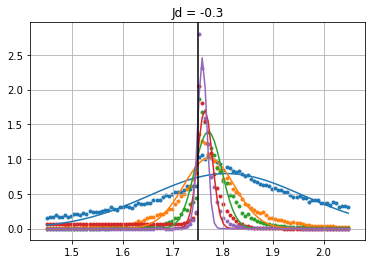

In [59]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))


def gaussian_fit(y, x):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False)
    return popt, pcov

popt_10, pcov_10 = gaussian_fit(y=errs(errs_10), x=T)
popt_20, pcov_20 = gaussian_fit(y=errs(errs_20), x=T)
popt_30, pcov_30 = gaussian_fit(y=errs(errs_30), x=T)
popt_60, pcov_60 = gaussian_fit(y=errs(errs_60), x=T)
popt_80, pcov_80 = gaussian_fit(y=errs(errs_80), x=T)

plt.figure()
plt.plot(T, gaussian(T, popt_10[0], popt_10[1], popt_10[2]), label='L=10', c='C0')
plt.scatter(T, errs(errs_10), label='L=10', marker='.', c='C0')

plt.plot(T, gaussian(T, popt_20[0], popt_20[1], popt_20[2]), label='L=20', c='C1')
plt.scatter(T, errs(errs_20), label='L=20', marker='.', c='C1')

plt.plot(T, gaussian(T, popt_30[0], popt_30[1], popt_30[2]), label='L=30', c='C2')
plt.scatter(T, errs(errs_30), label='L=30', marker='.', c='C2')

plt.plot(T, gaussian(T, popt_60[0], popt_60[1], popt_60[2]), label='L=60', c='C3')
plt.scatter(T, errs(errs_60), label='L=60', marker='.', c='C3')

plt.plot(T, gaussian(T, popt_80[0], popt_80[1], popt_80[2]), label='L=80', c='C4')
plt.scatter(T, errs(errs_80), label='L=80', marker='.', c='C4')

plt.axvline(x=T_c, color='black')
plt.title('Jd = -0.3')
fig.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

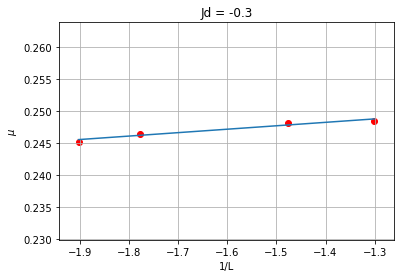

In [61]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = [1/L for L in [20, 30, 60, 80]]
cs = np.array([popt_20[1], popt_30[1], popt_60[1], popt_80[1]]) # mu

#popt_00, pcov_00 = line_fit(y=np.log10(np.abs(cs - T_c)), x=np.log10(ls))
pl_03 = np.polyfit(np.log10(ls), np.log10(cs), 1)

plt.scatter(np.log10(ls), np.log10(cs), color='red')
plt.plot(np.log10(ls), np.poly1d(pl_03)(np.log10(ls)))

plt.title('Jd = -0.3')
plt.xlabel('1/L')
plt.ylabel('$\mu$')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [62]:
Jd = -0.5
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

L = 10
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_10 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_10 = np.load(f)
    
L = 20
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_20 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_20 = np.load(f) 
    
L = 30
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_30 = np.load(f)
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_30 = np.load(f)
    
L = 60
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_60 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_60 = np.load(f) 

L = 80
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_80 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_80 = np.load(f)

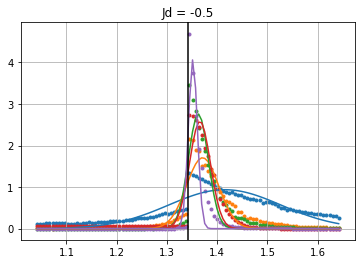

In [63]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))


def gaussian_fit(y, x):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False)
    return popt, pcov

popt_10, pcov_10 = gaussian_fit(y=errs(errs_10), x=T)
popt_20, pcov_20 = gaussian_fit(y=errs(errs_20), x=T)
popt_30, pcov_30 = gaussian_fit(y=errs(errs_30), x=T)
popt_60, pcov_60 = gaussian_fit(y=errs(errs_60), x=T)
popt_80, pcov_80 = gaussian_fit(y=errs(errs_80), x=T)

plt.figure()
plt.plot(T, gaussian(T, popt_10[0], popt_10[1], popt_10[2]), label='L=10', c='C0')
plt.scatter(T, errs(errs_10), label='L=10', marker='.', c='C0')

plt.plot(T, gaussian(T, popt_20[0], popt_20[1], popt_20[2]), label='L=20', c='C1')
plt.scatter(T, errs(errs_20), label='L=20', marker='.', c='C1')

plt.plot(T, gaussian(T, popt_30[0], popt_30[1], popt_30[2]), label='L=30', c='C2')
plt.scatter(T, errs(errs_30), label='L=30', marker='.', c='C2')

plt.plot(T, gaussian(T, popt_60[0], popt_60[1], popt_60[2]), label='L=60', c='C3')
plt.scatter(T, errs(errs_60), label='L=60', marker='.', c='C3')

plt.plot(T, gaussian(T, popt_80[0], popt_80[1], popt_80[2]), label='L=80', c='C4')
plt.scatter(T, errs(errs_80), label='L=80', marker='.', c='C4')

plt.axvline(x=T_c, color='black')
plt.title('Jd = -0.5')
fig.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

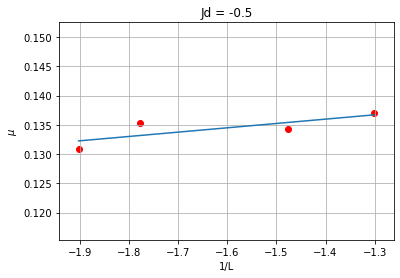

In [64]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = [1/L for L in [20, 30, 60, 80]]
cs = np.array([popt_20[1], popt_30[1], popt_60[1], popt_80[1]]) # mu

#popt_00, pcov_00 = line_fit(y=np.log10(np.abs(cs - T_c)), x=np.log10(ls))
pl_05 = np.polyfit(np.log10(ls), np.log10(cs), 1)

plt.scatter(np.log10(ls), np.log10(cs), color='red')
plt.plot(np.log10(ls), np.poly1d(pl_05)(np.log10(ls)))

plt.title('Jd = -0.5')
plt.xlabel('1/L')
plt.ylabel('$\mu$')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [65]:
Jd = -0.7
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

L = 10
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_10 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_10 = np.load(f)
    
L = 20
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_20 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_20 = np.load(f) 
    
L = 30
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_30 = np.load(f)
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_30 = np.load(f)
    
L = 60
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_60 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_60 = np.load(f) 

L = 80
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_80 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_80 = np.load(f)

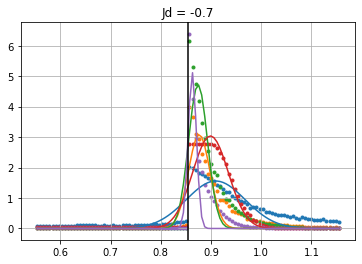

In [66]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))


def gaussian_fit(y, x):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False)
    return popt, pcov

popt_10, pcov_10 = gaussian_fit(y=errs(errs_10), x=T)
popt_20, pcov_20 = gaussian_fit(y=errs(errs_20), x=T)
popt_30, pcov_30 = gaussian_fit(y=errs(errs_30), x=T)
popt_60, pcov_60 = gaussian_fit(y=errs(errs_60), x=T)
popt_80, pcov_80 = gaussian_fit(y=errs(errs_80), x=T)

plt.figure()
plt.plot(T, gaussian(T, popt_10[0], popt_10[1], popt_10[2]), label='L=10', c='C0')
plt.scatter(T, errs(errs_10), label='L=10', marker='.', c='C0')

plt.plot(T, gaussian(T, popt_20[0], popt_20[1], popt_20[2]), label='L=20', c='C1')
plt.scatter(T, errs(errs_20), label='L=20', marker='.', c='C1')

plt.plot(T, gaussian(T, popt_30[0], popt_30[1], popt_30[2]), label='L=30', c='C2')
plt.scatter(T, errs(errs_30), label='L=30', marker='.', c='C2')

plt.plot(T, gaussian(T, popt_60[0], popt_60[1], popt_60[2]), label='L=60', c='C3')
plt.scatter(T, errs(errs_60), label='L=60', marker='.', c='C3')

plt.plot(T, gaussian(T, popt_80[0], popt_80[1], popt_80[2]), label='L=80', c='C4')
plt.scatter(T, errs(errs_80), label='L=80', marker='.', c='C4')

plt.axvline(x=T_c, color='black')
plt.title('Jd = -0.7')
fig.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

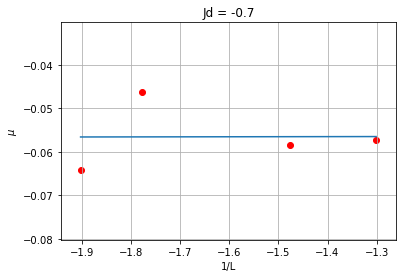

In [67]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = [1/L for L in [20, 30, 60, 80]]
cs = np.array([popt_20[1], popt_30[1], popt_60[1], popt_80[1]]) # mu

#popt_00, pcov_00 = line_fit(y=np.log10(np.abs(cs - T_c)), x=np.log10(ls))
pl_07 = np.polyfit(np.log10(ls), np.log10(cs), 1)

plt.scatter(np.log10(ls), np.log10(cs), color='red')
plt.plot(np.log10(ls), np.poly1d(pl_07)(np.log10(ls)))

plt.title('Jd = -0.7')
plt.xlabel('1/L')
plt.ylabel('$\mu$')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [68]:
Jd = -0.9
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

L = 10
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_10 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_10 = np.load(f)
    
L = 20
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_20 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_20 = np.load(f) 
    
L = 30
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_30 = np.load(f)
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_30 = np.load(f)
    
L = 60
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_60 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_60 = np.load(f) 

L = 80
with open(f'data_errors/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    errs_80 = np.load(f) 
with open(f'data_outputs/{Jd}_{L}_{num_temps}.npy', 'rb') as f:
    outs_80 = np.load(f)

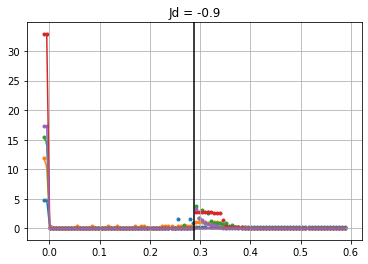

In [69]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))


def gaussian_fit(y, x):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False)
    return popt, pcov

popt_10, pcov_10 = gaussian_fit(y=errs(errs_10), x=T)
popt_20, pcov_20 = gaussian_fit(y=errs(errs_20), x=T)
popt_30, pcov_30 = gaussian_fit(y=errs(errs_30), x=T)
popt_60, pcov_60 = gaussian_fit(y=errs(errs_60), x=T)
popt_80, pcov_80 = gaussian_fit(y=errs(errs_80), x=T)

plt.figure()
plt.plot(T, gaussian(T, popt_10[0], popt_10[1], popt_10[2]), label='L=10', c='C0')
plt.scatter(T, errs(errs_10), label='L=10', marker='.', c='C0')

plt.plot(T, gaussian(T, popt_20[0], popt_20[1], popt_20[2]), label='L=20', c='C1')
plt.scatter(T, errs(errs_20), label='L=20', marker='.', c='C1')

plt.plot(T, gaussian(T, popt_30[0], popt_30[1], popt_30[2]), label='L=30', c='C2')
plt.scatter(T, errs(errs_30), label='L=30', marker='.', c='C2')

plt.plot(T, gaussian(T, popt_60[0], popt_60[1], popt_60[2]), label='L=60', c='C3')
plt.scatter(T, errs(errs_60), label='L=60', marker='.', c='C3')

plt.plot(T, gaussian(T, popt_80[0], popt_80[1], popt_80[2]), label='L=80', c='C4')
plt.scatter(T, errs(errs_80), label='L=80', marker='.', c='C4')

plt.axvline(x=T_c, color='black')
plt.title('Jd = -0.9')
fig.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [70]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = [1/L for L in [20, 30, 60, 80]]
cs = np.array([popt_20[1], popt_30[1], popt_60[1], popt_80[1]]) # mu

#popt_00, pcov_00 = line_fit(y=np.log10(np.abs(cs - T_c)), x=np.log10(ls))
pl_00 = np.polyfit(np.log10(ls), np.log10(cs), 1)

plt.scatter(np.log10(ls), np.log10(cs), color='red')
plt.plot(np.log10(ls), np.poly1d(pl_00)(np.log10(ls)))

plt.title('Jd = -0.9')
plt.xlabel('1/L')
plt.ylabel('$\mu$')
#plt.xscale('log')
#plt.yscale('log')
plt.show()


Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


LinAlgError: SVD did not converge in Linear Least Squares

In [71]:
10**pl_00[0], 10**pl_03[0], 10**pl_05[0], 10**pl_07[0]#, 10**pl_09[0]

(0.9949876278097876,
 1.0124137603527528,
 1.0171740526858613,
 1.0003597725023963)

In [72]:
10**(pl_00[1]), 10**(pl_03[1]), 10**(pl_05[1]), 10**(pl_07[1])#, 10**(pl_09[1])

(2.2545162718756315,
 1.8017774373573916,
 1.4006489851781525,
 0.8784869199046053)